In [1]:
! pip install langchain langchain-openai langchain-community langgraph python-dotenv faiss-cpu pypdf

     ---------------------------------------- 2.5/2.5 MB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 18.7/18.7 MB 4.4 MB/s eta 0:00:00
     -------------------------------------- 329.5/329.5 kB 5.1 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 4.8 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 4.5 MB/s eta 0:00:00
     -------------------------------------- 450.8/450.8 kB 5.6 MB/s eta 0:00:00
     -------------------------------------- 456.2/456.2 kB 9.5 MB/s eta 0:00:00
  Using cached dataclasses_json-0.6.7-py3-none-any.whl (28 kB)
     ---------------------------------------- 51.9/51.9 kB 2.6 MB/s eta 0:00:00
     ---------------------------------------- 13.1/13.1 MB 6.7 MB/s eta 0:00:00
  Using cached langgraph_checkpoint-2.1.2-py3-none-any.whl (45 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl (7.5 kB)
  Using cached attrs-25.4.0-py3-none

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langgraph-checkpoint-sqlite 3.0.0 requires langgraph-checkpoint<4.0.0,>=3, but you have langgraph-checkpoint 2.1.2 which is incompatible.

[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition

In [3]:
load_dotenv()

True

In [4]:
llm = ChatOpenAI(model='gpt-4o-mini')

In [5]:
loader = PyPDFLoader("intro-to-ml.pdf")
docs = loader.load()

In [6]:
len(docs)

392

In [7]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [8]:
len(chunks)

973

In [9]:
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')
vector_store = FAISS.from_documents(chunks, embeddings)

In [10]:
vector_store

In [11]:
retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})

In [12]:
@tool
def rag_tool(query):

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [13]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)

In [14]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [15]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}

In [16]:
tool_node = ToolNode(tools)

In [17]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

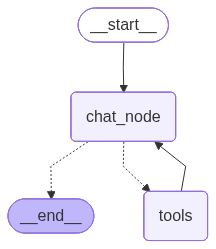

In [18]:
chatbot

In [19]:
result = chatbot.invoke(
    {
        "messages": [
            HumanMessage(
                content=(
                    "Using the pdf notes, explain how to find the ideal value of K in KNN"
                )
            )
        ]
    }
)

In [20]:
print(result['messages'][-1].content)

To find the ideal value of \( K \) in the k-Nearest Neighbors (k-NN) algorithm, you can follow these general guidelines:

1. **Understanding k-NN**: The k in k-NN indicates that instead of using only the closest neighbor, the algorithm can consider a fixed number \( K \) of neighbors to make predictions. The prediction is made based on the majority class among these neighbors.

2. **Choosing \( K \) Values**: There’s no one-size-fits-all answer for the ideal \( K \). Common practices include:
   - Selecting small values like \( K = 1 \) or \( K = 3 \) for simpler models.
   - Larger values of \( K \) might provide smoother decision boundaries but could lead to over-smoothing.

3. **Validation Techniques**: The ideal value of \( K \) is often found through validation techniques:
   - **Cross Validation**: Use techniques like k-fold cross-validation to evaluate the performance of the k-NN model at various \( K \) values.
   - **Grid Search**: Implement a grid search to systematically exp